## **Bienvenido a la tercera práctica de Jupyter Notebook**

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jpcano1/MINE-4101-tareas/blob/master/lab_4.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png"/>Run in Google Colab</a>
  </td>
</table>

## **Enunciado**
- En una entidad financiera de Portugal, se realizó una estrategia comercial con el fin de vender suscripciones de depósitos a plazo, esta campaña comercial se realizó mediante el uso de call center (cada cliente potencial fue contactado por llamada), con el fin de diseñar una nueva estrategia comercial más dirigida, y que optimice costos, la entidad financiera recolectó todos los resultados de sus campañas vía teléfonica. Los datos se encuentran en el [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing) junto a la descripción de las variables.

## **Actividad en Clase**
1. Realice una lectura de los datos utilizando Jupyter Notebook.
2. Realice un perfilamiento de los datos (usar pandas profiling) y describa el entendimiento del negocio a partir de este. 
3. Realice un proceso de limpieza de los datos en caso de ser necesario, justifique su respuesta*.
4. Plantee una hipótesis de interés para el negocio que al resolverlas puedan abarcar el problema planteado por la entidad financiera. 
5. A partir de los datos, valide su hipótesis.

## **Tarea**
1. Entregar en un jupyter notebook el numeral 1,2 y 3.
2. Plantee cuatro hipótesis de interés para el negocio que al resolverlas puedan abarcar el problema planteado por la entidad financiera. Justifique su respuesta en términos de los datos y análisis realizados para definirlas.
3. Valide por lo menos dos hipótesis planteadas en el ítem anterior, para ello, puede utilizar la práctica de correlaciones y pruebas chi cuadrado.
4. Teniendo en cuenta los resultados del punto 3, plantee una estrategia que permita a la entidad financiera vender más depósitos a plazo.

### **Diccionario de Variables**
#### **Input variables**
- **bank client data:**
1. **age** (numeric)
2. **job** : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. **marital** : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. **education** (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. **default**: has credit in default? (categorical: 'no','yes','unknown')
6. **housing**: has housing loan? (categorical: 'no','yes','unknown')
7. **loan**: has personal loan? (categorical: 'no','yes','unknown')

- **related with the last contact of the current campaign:**
8. **contact**: contact communication type (categorical: 'cellular','telephone')
9. **month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. **day_of_week**: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
- **other attributes:**
12. **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. **previous**: number of contacts performed before this campaign and for this client (numeric)
15. **poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
- **social and economic context attributes**
16. **emp.var.rate**: employment variation rate - quarterly indicator (numeric)
17. **cons.price.idx**: consumer price index - monthly indicator (numeric)
18. **cons.conf.idx**: consumer confidence index - monthly indicator (numeric)
19. **euribor3m**: euribor 3 month rate - daily indicator (numeric)
20. **nr.employed**: number of employees - quarterly indicator (numeric)

- **Output variable (desired target):**
21. **y**: has the client subscribed a term deposit? (binary: 'yes','no')

In [ ]:
!pip install -q https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
# Librería para hacer requests
import requests

# Librerías para manejo de archivos
import os
import zipfile
import sys

# Librería para experiencia de usuario
from tqdm import tqdm

# Librerías para manejo de datos
import numpy as np
import pandas as pd

# Librerías para gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# Librerías para análisis de datos.
from scipy import stats
import pandas_profiling

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"

## **Funciones Auxiliares**

In [90]:
def download_content(url, chnksz=1000, filename="image.jpg", zip=False):
    """
    Función que se encarga de descargar un archivo deseado
    :param url: la url de descarga
    :param filename: El nombre del archivo
    :param zip: Boolean que indica si lo que se descarga 
    es zipfile
    """
    try:
        r = requests.get(url)
    except Exception as e:
        print("Error de conexión con el servidor")
        sys.exit()
        
    with open(filename, "wb") as f:
        bar = tqdm(
            unit="KB",
            desc="Descargando archivos",
            total=int(
                np.ceil(int(r.headers["content-length"])/chnksz)
            )
        )

        for pkg in r.iter_content(chunk_size=chnksz):
            f.write(r.content)
            bar.update(int(len(pkg)/chnksz))
        bar.close()
    
    if zip:
        with zipfile.ZipFile(filename, "r") as zfile:
            print("\nExtrayedo Zip File...")
            zfile.extractall()
            print("Eliminando Zip File...")
            os.remove(filename)
    return

def null_percentage(df, int_mode=False):
    """
    Función encargada de calcular los porcentajes de nulidad 
    de cada columna del dataframe
    :param df: el dataframe
    :param int_mode: boolean que pregunta si la salida es 
    numérica
    :return: un diccionario con los porcentajes por columna.
    """
    null_percentages = dict()
    for col in df.columns:
        percentage = df[col].isna().sum() * 100
        percentage /= df.shape[0]
        if not int_mode:
            percentage = f"{percentage}% of null values"
        null_percentages[col] = percentage
    return null_percentages

def drop_null_column(df, drop_perc=85):
    """
    Función que se encarga de borrar las columnas con 
    un porcentaje de nulidad mayor al 85
    :param df: el dataframe
    :return: el dataframe limpio
    """
    null_perc = null_percentage(df, int_mode=True)
    for col in df.columns:
        if null_perc[col] > drop_perc:
            df.drop(columns=col, inplace=True)

def change_dtypes(df):
    for idx, dtype in zip(df.dtypes.index, df.dtypes.values):
        try:
            if dtype == "object":
                df[idx] = df[idx].astype("category")
            elif dtype == "int64":
                df[idx] = df[idx].astype("int16")
            elif dtype == "float64":
                df[idx] = df[idx].astype("float16")
        except Exception as e:
            print(e)
            continue

def get_cross_tab(index, columns):
    table = pd.crosstab(index=index, columns=columns, margins=True)
    table.index = [*table.index[:-1], f"total {index.name}"]
    table.columns = [*table.columns[:-1], f"total {columns.name}"]
    return table

def chi2test(table, ci=0.95):
    est, p_value, degrees_f, ex_freq = stats.chi2_contingency(table)
    alpha = 1. - ci
    print(f"Prueba de Chi2 con intervalo de confianza: {ci}")
    if p_value <= alpha:
        print("Se rechaza la H0")
    else:
        print("No hay pruebas suficientes para rechazar H0")

In [5]:
download_content(url, filename="file.zip", zip=True)

Descargando archivos: 100%|█████████▉| 444/445 [00:00<00:00, 2316.25KB/s]



Extrayedo Zip File...
Eliminando Zip File...


## **Lectura y Perfilamiento de los Datos**

In [6]:
data = pd.read_csv("./bank-additional/bank-additional-full.csv", delimiter=";", 
                   na_values=["unknown"])

In [7]:
data.head()

age        job  marital  ... euribor3m nr.employed   y
0   56  housemaid  married  ...     4.857      5191.0  no
1   57   services  married  ...     4.857      5191.0  no
2   37   services  married  ...     4.857      5191.0  no
3   40     admin.  married  ...     4.857      5191.0  no
4   56   services  married  ...     4.857      5191.0  no

[5 rows x 21 columns]

In [ ]:
pandas_profiling.ProfileReport(data)

## **Descripción del Negocio**

## **Limpieza de Datos**

In [8]:
data.head()

age        job  marital  ... euribor3m nr.employed   y
0   56  housemaid  married  ...     4.857      5191.0  no
1   57   services  married  ...     4.857      5191.0  no
2   37   services  married  ...     4.857      5191.0  no
3   40     admin.  married  ...     4.857      5191.0  no
4   56   services  married  ...     4.857      5191.0  no

[5 rows x 21 columns]

### **Arreglo de Tipos de Datos**
- Dado que en la gran mayoría de los casos tenemos tipos de datos `object`, sería bueno si cambiamos esos datos a `category`, igualmente con los `int64` para `int16` y los `float64` a `float16`

In [9]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [10]:
change_dtypes(data)

In [11]:
data.dtypes

age                  int16
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
duration             int16
campaign             int16
pdays                int16
previous             int16
poutcome          category
emp.var.rate       float16
cons.price.idx     float16
cons.conf.idx      float16
euribor3m          float16
nr.employed        float16
y                 category
dtype: object

### **Datos Duplicados**
- Dada la naturaleza del problema, lo mejor será no eliminar los duplicados, puesto que podrían ser información relavante.

In [12]:
data[data.duplicated()]

age          job   marital  ... euribor3m nr.employed    y
1266    39  blue-collar   married  ...  4.855469      5192.0   no
12261   36      retired   married  ...  4.964844      5228.0   no
14234   27   technician    single  ...  4.960938      5228.0   no
16956   47   technician  divorced  ...  4.960938      5228.0   no
18465   32   technician    single  ...  4.968750      5228.0   no
20216   55     services   married  ...  4.964844      5228.0   no
20534   41   technician   married  ...  4.964844      5228.0   no
25217   39       admin.   married  ...  4.152344      5196.0   no
28477   24     services    single  ...  1.422852      5100.0   no
32516   35       admin.   married  ...  1.313477      5100.0   no
36951   45       admin.   married  ...  1.072266      5076.0  yes
38281   71      retired    single  ...  0.742188      5016.0   no

[12 rows x 21 columns]

### **Completitud de los Datos**
- Dado que en el dataset no hay datos "nulos", se asumen los valores "unknown" como nulos, he aquí los porcentajes:

```python
{'age': '0.0% of null values',
 'campaign': '0.0% of null values',
 'cons.conf.idx': '0.0% of null values',
 'cons.price.idx': '0.0% of null values',
 'contact': '0.0% of null values',
 'day_of_week': '0.0% of null values',
 'default': '20.872584247839175% of null values',
 'duration': '0.0% of null values',
 'education': '4.202680392347285% of null values',
 'emp.var.rate': '0.0% of null values',
 'euribor3m': '0.0% of null values',
 'housing': '2.40361270272895% of null values',
 'job': '0.8012042342429834% of null values',
 'loan': '2.40361270272895% of null values',
 'marital': '0.1942313295134505% of null values',
 'month': '0.0% of null values',
 'nr.employed': '0.0% of null values',
 'pdays': '0.0% of null values',
 'poutcome': '0.0% of null values',
 'previous': '0.0% of null values',
 'y': '0.0% of null values'}
```

- Dado que no hay ninguna columna con un porcentaje de nulidad mayor al 80% no es necesario eliminar columnas. Aún así vamos a eliminar aquellas filas que tengan más de 2 variables nulas. De esta forma mantenemos el 99.2% de los datos

In [13]:
data.dropna(thresh=19, inplace=True)

### **Exactitud de los Datos**

In [14]:
for idx, val in zip(data.dtypes.index, data.dtypes.values):
    if val.name == "category":
        print(f"Valores de {idx}: {data[idx].unique()}")

Valores de job: [housemaid, services, admin., blue-collar, technician, ..., unemployed, self-employed, NaN, entrepreneur, student]
Length: 12
Categories (11, object): [housemaid, services, admin., blue-collar, ..., unemployed, self-employed,
                          entrepreneur, student]
Valores de marital: [married, single, divorced, NaN]
Categories (3, object): [married, single, divorced]
Valores de education: [basic.4y, high.school, basic.6y, basic.9y, professional.course, NaN, university.degree, illiterate]
Categories (7, object): [basic.4y, high.school, basic.6y, basic.9y, professional.course,
                         university.degree, illiterate]
Valores de default: [no, NaN, yes]
Categories (2, object): [no, yes]
Valores de housing: [no, yes, NaN]
Categories (2, object): [no, yes]
Valores de loan: [no, yes, NaN]
Categories (2, object): [no, yes]
Valores de contact: [telephone, cellular]
Categories (2, object): [telephone, cellular]
Valores de month: [may, jun, jul, aug, oct, 

In [15]:
data["age"].unique()

array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
       49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
       28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
       77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
       74, 17, 87, 91, 86, 98, 94, 84, 92, 89], dtype=int16)

## **Formulación de Hipótesis**
1. El estado marital de las personas influye positivamente con respecto a la suscripción de un depósito a término.
2. El resultado de la anterior campaña de marketing influye con respecto a la suscripción de un depósito a término.
3. La duración del último contacto influye con respecto a la suscripción de un depósito a término.
4. Los préstamos personales influyen con respecto a la suscripción de un depósito a término.

### **Hipótesis 1**

In [36]:
table_marital = get_cross_tab(data["marital"], data["y"])

In [40]:
table_marital

no   yes  total y
divorced        4114   472     4586
married        22179  2520    24699
single          9888  1615    11503
total marital  36181  4607    40788

In [42]:
# Frecuencias relativas totales
table_marital / table_marital.loc["total marital", "total y"]

no       yes   total y
divorced       0.100863  0.011572  0.112435
married        0.543763  0.061783  0.605546
single         0.242424  0.039595  0.282019
total marital  0.887050  0.112950  1.000000

In [43]:
# Frecuencias relativas a la columna
table_marital / table_marital.loc["total marital"]

no       yes   total y
divorced       0.113706  0.102453  0.112435
married        0.613001  0.546994  0.605546
single         0.273293  0.350554  0.282019
total marital  1.000000  1.000000  1.000000

In [45]:
# Frecuencias relativas a la variable
table_marital.div(table_marital["total y"], axis=0)

no       yes  total y
divorced       0.897078  0.102922      1.0
married        0.897972  0.102028      1.0
single         0.859602  0.140398      1.0
total marital  0.887050  0.112950      1.0

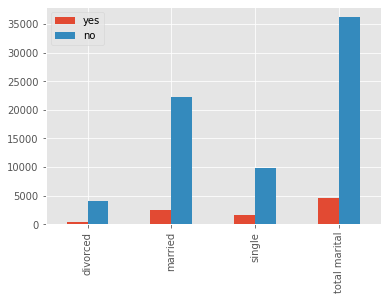

In [49]:
table_marital[["yes", "no"]].plot(kind="bar");

### **Hipótesis 2**

In [37]:
table_poutcome = get_cross_tab(data["poutcome"], data["y"])

In [52]:
# Frecuencias relativas totales
table_poutcome / table_poutcome.loc["total poutcome", "total y"]

no       yes   total y
failure         0.088962  0.014660  0.103622
nonexistent     0.786344  0.076530  0.862873
success         0.011698  0.021806  0.033505
total poutcome  0.887004  0.112996  1.000000

In [53]:
# Frecuencias relativas a la columna
table_poutcome / table_poutcome.loc["total poutcome"]

no       yes   total y
failure         0.100295  0.129738  0.103622
nonexistent     0.886516  0.677280  0.862873
success         0.013189  0.192982  0.033505
total poutcome  1.000000  1.000000  1.000000

In [54]:
# Frecuencias relativas a la variable
table_poutcome.div(table_poutcome["total y"], axis=0)

no       yes  total y
failure         0.858526  0.141474      1.0
nonexistent     0.911308  0.088692      1.0
success         0.349160  0.650840      1.0
total poutcome  0.887004  0.112996      1.0

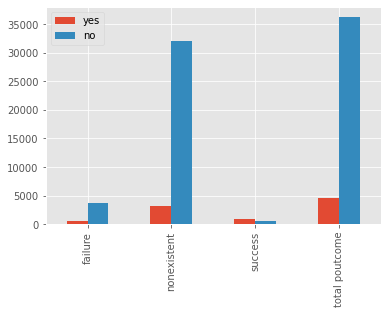

In [56]:
table_poutcome[["yes", "no"]].plot(kind="bar");

### **Hipótesis 3**

In [76]:
table_duration = (data.groupby("y").duration.agg(["mean", "std", "sem"])
.style.background_gradient(cmap="RdBu", axis=0))

In [77]:
table_duration

- Como se puede ver en el siguiente plot, la variable objetivo está fuertemente influenciada por la duración del último contacto, dado que si la duración fue cero, entonces la suscripción es negativa.

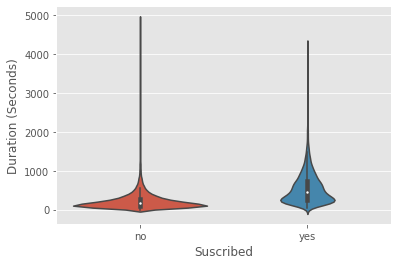

In [75]:
sns.violinplot(x="y", y="duration", data=data)
plt.ylabel("Duration (Seconds)")
plt.xlabel("Suscribed")
plt.show()

### **Hipótesis 4**

In [57]:
table_loan = get_cross_tab(data["loan"], data["y"])

In [61]:
# Frecuencias relativas totales
table_loan / table_loan.loc["total loan", "total y"]

no       yes   total y
no          0.748586  0.095835  0.844421
yes         0.138606  0.016974  0.155579
total loan  0.887191  0.112809  1.000000

In [62]:
# Frecuencias relativas a la columna
table_loan / table_loan.loc["total loan"]

no       yes   total y
no          0.84377  0.849536  0.844421
yes         0.15623  0.150464  0.155579
total loan  1.00000  1.000000  1.000000

In [63]:
# frecuencias relativas a la variable
table_loan.div(table_loan["total y"], axis=0)

no       yes  total y
no          0.886508  0.113492      1.0
yes         0.890900  0.109100      1.0
total loan  0.887191  0.112809      1.0

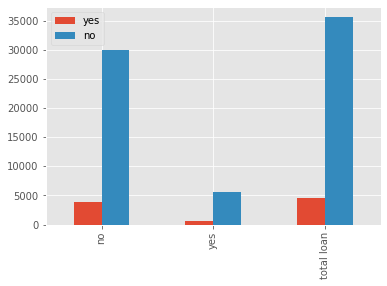

In [78]:
table_loan[["yes", "no"]].plot(kind="bar")

## **Pruebas de Hipótesis**
1. **Hipótesis 1**: La duración del último contacto influye con respecto a la suscripción de un depósito a término.
2. **Hipótesis 2**: Los préstamos personales influyen con respecto a la suscripción de un depósito a término.

### **Correlación Biserial para la Hipótesis 1**
- Usando el método de pearson para calcular la correlación entre variables, se puede ver que la correlación entre la duración del último contacto tiene un coeficiente de 0.4, lo que no indica fuerte correlación, pero tampoco indica independencia.

In [80]:
data["y_num"] = (data["y"] == "yes").astype("int")

In [89]:
data[["duration", "y_num"]].corr(method="pearson")

duration     y_num
duration  1.000000  0.405246
y_num     0.405246  1.000000

### **Prueba de $\chi^2$ para la hipótesis 2**

In [97]:
crosstab = pd.crosstab(index=data["loan"], columns=data["y"])

In [98]:
chi2test(crosstab)

Prueba de Chi2 con intervalo de confianza: 0.95
No hay pruebas suficientes para rechazar H0
